In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import os
import numpy as np 
from numpy import abs as Abs
from numpy import sign as sign
from numpy import sqrt,pi,array

from control.matlab import *  # MATLAB-like functions
import control as ct
# from scipy import signal
from scipy.signal import cont2discrete, lti, dlti, dstep
 
import matplotlib
import matplotlib.pyplot as plt
 
import tensorflow as tf
from gym import Env
from gym.spaces import Discrete, Box
 
import random
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [3]:
n = 8
r = 3
M = np.load('M.npy')
C = np.load('C.npy')
K = np.load('K.npy')
# Ad = np.load('Ad.npy')
# Bd = np.load('Bd.npy')
# Ed = np.load('Ed.npy')
# Cd = np.load('Cd.npy')
# Dd = np.load('Dd.npy')

In [4]:
# State space representation
I = -1*np.ones([n,1])  # Influence vector
gamma = np.array([[ 1.,  0.,  0.],
                  [ 0.,  0.,  0.],
                  [ 0., -1.,  0.],
                  [ 0.,  1.,  0.],
                  [ 0.,  0., -1.],
                  [ 0.,  0.,  1.],
                  [ 0.,  0.,  0.],
                  [ 0.,  0.,  0.]])
A1 = np.zeros([n,n])
A2 = np.identity(n)
A3 = -1*np.linalg.inv(M) @ K
A4 = -1*np.linalg.inv(M) @ C
A = np.zeros([2*n,2*n])
A[0:n,n:2*n] = A2
A[n:2*n,0:n] = A3
A[n:2*n,n:2*n] = A4
# = np.ones((n,n), dtype=int)
# print(A)  
B = np.zeros((2*n,r))
B[n:2*n,0:r] = np.linalg.inv(M) @ gamma   # Input matrix
# print(B)
E = np.zeros((2*n,1))
E[n:2*n] = I   # Input matrix
# print(E)
# Output matrix (Disp + Accel)
Cd = np.zeros([n+r, 2*n])
Cd[0:n, 0:n] = A3;
Cd[0:n, n:2*n] = A4;
Cd[n,0:2] =  np.array([[1, 1]])
Cd[n+1,2:5] =  np.array([[1, 1, 1]])
Cd[n+2,5:8] =  np.array([[1, 1, 1]])
# print(Cd)
Dd = np.zeros([n+r, r])
Dd[0:n,0:r] = np.linalg.inv(M) @ gamma   # Input matrix
# print(Dd)
Ed1 = np.zeros([n+r,1])
# print(Ed)
# Cd = np.array([[1, 0, 0, 0]])
# Dd = np.array([[0]]).transpose()  
# Ed = np.array([[0]]).transpose()
# del M, m, Ks, Cs, Kt

In [5]:
np.save('A1.npy', A)
np.save('B1.npy', B)
np.save('E1.npy', E)
np.save('Cd1.npy', Cd)
np.save('Dd1.npy', Dd)
np.save('Ed1.npy', Ed1)

In [6]:
# Discrete System
d_system = cont2discrete((A, np.concatenate((B, E), axis=1), Cd, np.concatenate((Dd, Ed1), axis=1)), 0.02, method='zoh')
Ad = d_system[0]
Bd1 = d_system[1]
Bd = Bd1[:,0:3]
Ed = Bd1[:,3:4]
from numpy.linalg import matrix_rank
ko = matrix_rank(ctrb(Ad, Bd))
if ko == len(Ad):
  print("System is controllable")
else:
  print("System is uncontrollable")
del d_system, Bd1, ko

System is controllable


In [7]:
# Weighting matrices
Q = np.identity(2*n)
# Q = np.zeros([2*n, 2*n])
# Q[0:n, 0:n] = K
# Q[n:2*n, n:2*n] = M
(i,j) = Bd.shape
R =  (10**(-14))*np.identity(j)
del i, j
Kp, Sp, ep = ct.dlqr(Ad, Bd, Q, R)

In [8]:
class MrDamperEnv(Env):

    def __init__(self):
    
      self.n = 8    # Number of storey
      self.r = 3    # no of MR dampers
      # 1000kN MR damper
      self.vmax = 10
      self.vmin = 0
      self.gamma = 141
      self.beta = 141
      self.Ad = 2074.5
      self.nd = 2
      self.eta = 100
      self.alpha0 = 26.0*10**3
      self.alpha1 = 29.1*10**3
      self.c01 = 105.4*10**3
      self.c02 = 131.6*10**3
      self.k01 = 0
      self.k02 = 0
      self.umin = 0.02  
      self.umax = 1 

      
      # Plant matrices (Continous)
      self.A = np.load('A1.npy')
      self.B = np.load('B1.npy')
      self.E = np.load('E1.npy')
      self.Cd = np.load('Cd1.npy')
      self.Dd = np.load('Dd1.npy')
      self.Ed1 = np.load('Ed1.npy')
      self.M = np.load('M.npy')
      self.C = np.load('C.npy')
      self.K = np.load('K.npy')
      self.An = self.A
      self.Cdn = self.Cd
        
      # Plant matrices (discrete) 
      d_system = cont2discrete((self.A, np.concatenate((self.B, self.E), axis=1), self.Cd, np.concatenate((self.Dd, self.Ed1), axis=1)), 0.02, method='zoh')
      self.Ad = d_system[0]
      Bd1 = d_system[1]
      self.Bd = Bd1[:,0:3]
      self.Ed = Bd1[:,3:4]
          
      # Weighting matrices
      self.Q = np.identity(2*self.n)
      #self.Q = np.zeros([2*self.n, 2*self.n])
      #self.Q[0:self.n, 0:self.n] = self.K
      #self.Q[self.n:2*self.n, self.n:2*self.n] = self.M
      (i,j) = self.B.shape
      self.R =  (10**(-14))*np.identity(j)
      del i, j

      # Output matrix (Disp + Accel)
      #self.Cd = np.array([[1, 1, 0, 0], [-self.Ks/self.M, self.Ks/self.M, 0, 0], [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
      #self.Dd = np.array([[0, 1/self.M, -1/self.m]]).T
      #self.Ed = np.array([[0, 0, 0]]).T
    
              
      # Input per episode
      GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])
      a = np.random.randint(low=1,high=10)

      if a < 10:
        f = "la"+"%02d" % GM[a]  + ".dat"
      else:
        f = "la"+"%02d" % GM[a]  + ".dat"
      #print(f)
      self.xacc = (np.array(np.loadtxt(f)).flatten())/100  # Convert cm/s2 to m/s2
      #print(c)
      
      # Time series for ground motion
      GMdt = np.loadtxt('GMdt.txt', unpack = True)
      #print(len(GMdt))
      self.dt = GMdt[GM[a]-1]
      #print(self.dt)
      tend = self.dt*len(self.xacc)
      self.t = np.arange(0, tend, self.dt)
      nt = self.t.size
      #plt.figure()
      #plt.plot(self.t, self.xacc)
      del a, f, GMdt, tend   
      
          
      # Initialize variables
      self.time_current = 0
      self.state = np.zeros([nt, 2*self.n]) # states (ys,ysdot,yt,ytdot)
      self.U = np.zeros([nt, self.r]) # Control force (action)
      self.Re = np.zeros([nt, 1]) # Reward
      self.J_val = 0
      self.action_space = Box(low=np.array([-6e6, -6e6, -6e6]), high=np.array([6e6, 6e6, 6e6]),shape=(3,))
      self.observation_space = Box(low=np.array([-100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000]), high=np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]) )
      self.statem = np.zeros([1, 2*self.n])
      self.K = np.zeros([2*self.n, 2*self.n])
      self.Volt = np.zeros([nt, 1])
      self.hr = []

    def step(self, action):
          tim = self.time_current  # current time (size 1)
          
          # System model in discrete time
          Q = self.Q
          R = self.R  
          n = self.n
          r = self.r
          M = self.M 
          dt = self.dt
          umin = self.umin  
          umax = self.umax
            
          Kp, Sp, ep = ct.dlqr(self.Ad, self.Bd, self.Q, self.R)
          Bj = self.Bd@(-Kp)
            
          # Control action
          K = self.K
          #print(K)
          action1 = np.squeeze(action)
          state = np.array([self.state[tim, :]]).T
          val = ((state.T)@K)@(state)
        
          if(val[0] >= 0):
                action2 = (umin*(-Kp@state)) + np.array([action1]).T
                self.U[tim, :] = np.squeeze(action2.T)    # control force
                self.Volt[tim, :] = umin
          else:
                action2 = (umax*(-Kp@state)) + np.array([action1]).T
                self.U[tim, :] = np.squeeze(action2.T)    # control force
                self.Volt[tim, :] = umax
          del action1, action2
          action1 = np.array([self.U[tim, :]]).T
          #print(action1)
          #print(action)
        
          self.J = 0
          z = 10 + tim
          i = 0
          for tkk in range(tim, z):
            h = self.xacc[tkk] 
            self.hr.append(h)
            xn = state
            #print(xn)
            K1 = 3444*10**5
            Dy = 0.012
            Fy = K1*Dy
            # Uncontrolled
            if(xn[0,0]>=Dy):

                kk = Fy/xn[0,0]
                #print(xpn[tkk,0,i], kk)
                Kn = 2*np.diag(np.full(n,kk))
                Kn[n-1,n-1] = kk
                for x in range(n-1):
                  Kn[x,x+1] = -kk
                  Kn[x+1,x] = -kk
                A3n = -1*np.linalg.inv(M) @ Kn
                self.An[n:2*n,0:n] = A3n
                self.Cdn[0:n, 0:n] = A3n
                d_system_n = cont2discrete((self.An, np.concatenate((self.B, self.E), axis=1), self.Cdn, np.concatenate((self.Dd, self.Ed1), axis=1)), dt, method='zoh')
                Adn = d_system_n[0]
                Bd1 = d_system_n[1]
                Bdn = Bd1[:,0:3]
                Edn = Bd1[:,3:4]
                del kk, Kn, A3n
                # Control Results
                yn1 = (self.Cdn @ xn) + (self.Dd @ action1)
                xn1 = (Adn @ xn) + (Bdn @ action1) + (Edn * h)
                del Adn, Bdn, Edn
            else:
                yn1 = (self.Cd @ xn) + (self.Dd @ action1)
                xn1 = (self.Ad @ xn) + (self.Bd @ action1) + (self.Ed * h)    
                state = xn1

            self.En = 0.1*((state.T@Q)@state)
            #print(self.E)
            self.J = self.J + dt*(0.9**i)*(self.En)
            
            if(i==0):
              self.statem = state.T
              self.J_val += self.J 
            i = i+1
          #print("kkk ",self.J_val)
          #print(self.J) 
          done = False
          #print(f1)
          info = {}   
          reward = -1*self.J
          self.Re[tim+1, :] = reward
          self.state[tim+1, :] = self.statem

          return self.statem[0], reward, done, info

    def reset(self):
    
      self.n = 8    # Number of storey
      self.r = 3    # no of MR dampers
      # 1000kN MR damper
      self.vmax = 10
      self.vmin = 0
      self.gamma = 141
      self.beta = 141
      self.Ad = 2074.5
      self.nd = 2
      self.eta = 100
      self.alpha0 = 26.0*10**3
      self.alpha1 = 29.1*10**3
      self.c01 = 105.4*10**3
      self.c02 = 131.6*10**3
      self.k01 = 0
      self.k02 = 0
      self.umin = 0.02  
      self.umax = 1 

      
      # Plant matrices (Continous)
      self.A = np.load('A1.npy')
      self.B = np.load('B1.npy')
      self.E = np.load('E1.npy')
      self.Cd = np.load('Cd1.npy')
      self.Dd = np.load('Dd1.npy')
      self.Ed1 = np.load('Ed1.npy')
      self.M = np.load('M.npy')
      self.C = np.load('C.npy')
      self.K = np.load('K.npy')
      self.An = self.A
      self.Cdn = self.Cd
        
      # Plant matrices (discrete) 
      d_system = cont2discrete((self.A, np.concatenate((self.B, self.E), axis=1), self.Cd, np.concatenate((self.Dd, self.Ed1), axis=1)), 0.02, method='zoh')
      self.Ad = d_system[0]
      Bd1 = d_system[1]
      self.Bd = Bd1[:,0:3]
      self.Ed = Bd1[:,3:4]
          
      # Weighting matrices
      self.Q = np.identity(2*self.n)
      #self.Q = np.zeros([2*self.n, 2*self.n])
      #self.Q[0:self.n, 0:self.n] = self.K
      #self.Q[self.n:2*self.n, self.n:2*self.n] = self.M
      (i,j) = self.B.shape
      self.R =  (10**(-14))*np.identity(j)
      del i, j

      # Output matrix (Disp + Accel)
      #self.Cd = np.array([[1, 1, 0, 0], [-self.Ks/self.M, self.Ks/self.M, 0, 0], [self.Ks/self.m, -1*(self.Ks+self.Kt)/self.m, 0, 0]])
      #self.Dd = np.array([[0, 1/self.M, -1/self.m]]).T
      #self.Ed = np.array([[0, 0, 0]]).T
    
              
      # Input per episode
      GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])
      a = np.random.randint(low=1,high=10)

      if a < 10:
        f = "la"+"%02d" % GM[a]  + ".dat"
      else:
        f = "la"+"%02d" % GM[a]  + ".dat"
      #print(f)
      self.xacc = (np.array(np.loadtxt(f)).flatten())/100  # Convert cm/s2 to m/s2
      #print(c)
      
      # Time series for ground motion
      GMdt = np.loadtxt('GMdt.txt', unpack = True)
      #print(len(GMdt))
      self.dt = GMdt[GM[a]-1]
      #print(self.dt)
      tend = self.dt*len(self.xacc)
      self.t = np.arange(0, tend, self.dt)
      nt = self.t.size
      #plt.figure()
      #plt.plot(self.t, self.xacc)
      del a, f, GMdt, tend   
      
          
      # Initialize variables
      self.time_current = 0
      self.state = np.zeros([nt, 2*self.n]) # states (ys,ysdot,yt,ytdot)
      self.U = np.zeros([nt, self.r]) # Control force (action)
      self.Re = np.zeros([nt, 1]) # Reward
      self.J_val = 0
      self.action_space = Box(low=np.array([-6e6, -6e6, -6e6]), high=np.array([6e6, 6e6, 6e6]),shape=(3,))
      self.observation_space = Box(low=np.array([-100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000]), high=np.array([100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]) )
      self.statem = np.zeros([1, 2*self.n])
      self.K = np.zeros([2*self.n, 2*self.n])
      self.Volt = np.zeros([nt, 1])
      self.hr = []

      return self.state[0, :]


env = MrDamperEnv()

C:\Users\91735\anaconda3\envs\tf-gpu-new\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [9]:
states = env.observation_space.shape
num_states = states[0]
print("Size of State Space ->  {}".format(num_states))
actions = env.action_space.shape
num_actions = actions[0]
print("Size of Action Space ->  {}".format(num_actions))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  16
Size of Action Space ->  3
Max Value of Action ->  6000000.0
Min Value of Action ->  -6000000.0


In [10]:
env.action_space.sample()

array([-4297534. ,  4972410.5, -5396658.5], dtype=float32)

In [11]:
env.observation_space.sample()

array([-81066.586 ,  59774.344 , -83927.38  , -66159.73  , -63481.164 ,
       -88396.91  , -86786.96  ,  11938.501 , -13998.425 ,  92785.41  ,
        88019.945 ,  -7636.3696,   6276.4346, -38908.523 ,  -6837.0415,
       -64763.28  ], dtype=float32)

In [12]:
# for ep in range(10):
#     prev_state = env.reset()
#     episodic_reward = 0
#     for tim in range(0,len(env.t)-20): 
#         env.time_current = tim
#         tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
#         action = env.action_space.sample()
#         state, reward, done, info = env.step(action)
#         episodic_reward += reward
#         prev_state = state
#         print('tim:{} action:{} reward:{} state:{}'.format(tim, action, reward, state))

#     print(env.J_val)

In [13]:
 class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
         
        x = ( self.x_prev+ self.theta * (self.mean - self.x_prev) * self.dt + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape))
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [14]:
 class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
       
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.buffer_counter = 0
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
      
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1


    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
       
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [15]:
 def get_actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(3, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(3)(out)
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [16]:
 def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [22]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.001
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
gamma = 0.0001
tau = 0.9

buffer = Buffer(100000, 64)

In [23]:
# Initial controller gain
Bj = np.array(Bd @ (-1*Kp)) 
A1 = Ad.T + Bj.T 
P = dlyap(A1, -Q)
K0 = P@Bj
# P = np.array([[-5.60388195e+02,  1.85873971e+02, -3.35420000e+02, -5.03729674e+00],
#                [ 1.85873971e+02, -2.01982759e+03,  4.26409397e+02, -3.23571106e+01],
#                [-3.35420000e+02,  4.26409397e+02, -1.14986282e+04, -1.02322121e+02],
#                [-5.03729674e+00, -3.23571106e+01, -1.02322121e+02, -4.55606248e+02]])
# Bj  = np.array([[0,0,0,0], [0,0,0,0], [-0.49590136/env.M, 1.14546156/env.M, -35.69758159/env.M, 11.83173935/env.M], [0.49590136/env.m, -1.14546156/env.m, 35.69758159/env.m, -11.83173935/env.m]])  
K = np.zeros([2*env.n, 2*env.n, total_episodes])
K[0:2*env.n,0:2*env.n,0] = K0
umin = 0.02
umax = 1
alpha = 6.0
s = []  # number of tau_s

# Reward list
ep_reward_list = np.zeros([4000, 1, total_episodes])  
ep_reward_list1 = []
avg_reward_list = []

#  Cost function 
ep_Jval_list = np.zeros([total_episodes, 1])

#  Action and state 
ep_Action_list = np.zeros([4000, env.r, total_episodes])
ep_State_list = np.zeros([4000, 2*env.n, total_episodes])
ep_AdState_list = np.zeros([4000, 2*env.n, total_episodes])  # Adjoint state
dj_dk = np.zeros([2*env.n, 2*env.n, total_episodes])  # Gradient

for ep in range(0, total_episodes-1):
    prev_state = env.reset()
    episodic_reward = 0
    env.K = K[0:2*env.n,0:2*env.n,ep]
    nt = len(env.t)
    #print(env.K)
    for time in range(0,nt-10):
        env.time_current = time
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state, ou_noise)
        #print(action)
        # Action List
        state, reward, done, info = env.step(action)
        #print(action)
        buffer.record((prev_state, np.squeeze(action), reward, state))
        episodic_reward += reward
        # Reward list
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        prev_state = state
        
    ep_Action_list[0:nt, :, ep] = np.squeeze(env.U)
    ep_State_list[0:nt, :, ep] = env.state
    ep_reward_list[0:nt, :, ep] = env.Re
    
    ep_Jval_list[ep, :] = np.array([env.J_val])
    ep_reward_list1.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list1[-40:])
    avg_reward_list.append(avg_reward)
    print("Episode * {} * Reward is ==> {} * J_value is ==> {}".format(ep, episodic_reward, env.J_val))
        

    # Adjoint State 
    s.append([])
    for time in range(0,nt-10):
        i = nt-11-time
        #print(i)
        xn = np.array([ep_State_list[i,:,ep]]).T
        val = ((xn.T)@env.K)@(xn)
        #print(val)
        if(val[0]==0):
            pn = np.array([ep_AdState_list[i,:,ep]]).T
            s[ep].append(i)
            d_ptau = ((umin-umax)*((pn.T@ Bj)@xn))*((env.K + env.K.T)@xn)      #1*(1*1)*((n*n)@(n*1))  #############
            #d_ptau = (d_ptau1[0,0]*xn)      #1*(1*1)*((n*n)@(n*1))  #############
            #print(d_ptau)
            pnb1 = pn + d_ptau  # (n*1)
            ep_AdState_list[i-1,:,ep] = pnb1.T
        else:
            if(val[0] < 0.001 and val[0] > -0.001):
                s[ep].append(i)
            if(val[0]>=0):
                va = umin
            else:
                va = umax
            pn = np.array([ep_AdState_list[i,:,ep]]).T
            F = env.Q@xn 
            S = -va*(Bj.T)
            pnb1 = (-Ad.T @ pn) + (S @ pn) + (F)
            ep_AdState_list[i-1,:,ep] = pnb1.T
            #print(p[i-1,:,id]                      
                                  
            #F = env.Q@xn
            #S = -va*(Bj.T)      
            #k1 = -env.dt*(-env.A.T@pn + S@pn + F)             ##-G@pn-val*B.T@pn+Q@(e[id].T)
            #k2 = -env.dt*(-env.A.T@(pn +0.5*k1)+ S@(pn +0.5*k1)+ F)
            #k3 = -env.dt*(-env.A.T@(pn +0.5*k2)+ S@(pn +0.5*k2)+ F)
            #k4 = -env.dt*(-env.A.T@(pn +k3)+ S@(pn +k3)+ F)
            #pnb1 = pn + (k1 + 2*k2 + 2*k3 + k4)/6
            
            #print(p[i-1,:,id])
        del xn, val, pn, pnb1, i
    
    # Evaluate dj/dk
    sum = dj_dk[0:2*env.n,0:2*env.n,ep]
    print(len(s[ep]))
    if(len(s[ep])>0):
        for j in s[ep]:
            xn = np.array([ep_State_list[j,:,ep]]).T
            pn = np.array([ep_AdState_list[j,:,ep]]).T
            sum = sum +  -1*(umin-umax)*((pn.T@Bj)@xn)*(xn@xn.T)
        #print(sum)
        dj_dk[0:2*env.n,0:2*env.n,ep] = sum
        # Update K 
        K[0:2*env.n,0:2*env.n,ep+1] = K[0:2*env.n,0:2*env.n,ep]  - alpha*dj_dk[0:2*env.n,0:2*env.n,ep]
    else:
        print(np.linalg.norm(dj_dk[0:2*env.n,0:2*env.n,ep]))
    #break
    
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()

np.savetxt("8_story_PG_nonlinear.txt",ep_reward_list.flatten())
np.savetxt("8_story_PG_avg_nonlinear.txt",avg_reward_list.flatten())

# Save the weights
# actor_model.save_weights("8story_actor_DDPG_PG.h5")
# critic_model.save_weights("8story_critic_DDPG_PG.h5")

# target_actor.save_weights("8story_target_actor_DDPG_PG.h5")
# target_critic.save_weights("8story_target_critic_DDPG_PG.h5")
    

la14.dat


KeyboardInterrupt: 

In [26]:
np.savetxt("8_story_PG_nonlinear.txt",ep_reward_list.flatten())
np.savetxt("8_story_PG_avg_nonlinear.txt",avg_reward_list)
np.savetxt("8story_PG_ep_Jval_list_PG.txt",ep_Jval_list)
np.save('8story_PG_ep_Action_list_PG.npy', ep_Action_list)
np.save('8story_PG_ep_State_list_PG.npy', ep_State_list)
np.save('8story_PG_ep_reward_list_PG.npy', ep_reward_list) 

In [27]:
# Save the weights
# Save the weights
actor_model.save_weights("8story_actor_DDPG_PG_G0p0001T0p9_N.h5")
critic_model.save_weights("8story_critic_DDPG_PG_G0p0001T0p9_N.h5")

target_actor.save_weights("8story_target_actor_DDPG_G0p0001T0p9_N.h5")
target_critic.save_weights("8story_target_critic_DDPG_G0p0001T0p9_N.h5")

In [ ]:
plt.plot(avg_reward_list)
np.save('Reward_DDPG_VW.npy', avg_reward_list)

In [ ]:
DS['zmean'][0]=0
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 24

figure1=plt.figure(figsize = (12, 2))
xr = np.array(range(len(D[1,:])))
plt.stem(xr,DS['zmean'], use_line_collection = True, linefmt='blue', basefmt="k")
plt.axhline(y= 0.5, color='r', linestyle='-.')
plt.ylabel('PIP', fontweight='bold');
plt.title('(c) Third dof', fontweight='bold',fontsize=24)
plt.grid(True); plt.ylim(0,1.05)
plt.xticks(fontweight='bold'); plt.yticks(fontweight='bold');
figure1.savefig('TMD_drift3.pdf',format='pdf',dpi=600,bbox_inches='tight')

In [ ]:
plt.plot(ep_State_list[0:nt, 0, 992])
np.save('Disp0_DDPG_PG_CW.npy', ep_State_list[0:nt, 0, 992])
np.save('Disp7_DDPG_PG_CW.npy', ep_State_list[0:nt, 7, 992])
np.save('Vel0_DDPG_PG_CW.npy', ep_State_list[0:nt, 8, 992])
np.save('Vel7_DDPG_PG_CW.npy', ep_State_list[0:nt, 15, 992])

In [17]:
del actor_model 
del critic_model

del target_actor 
del target_critic 
del policy

NameError: name 'actor_model' is not defined

In [18]:
actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()
def policy(state):
    sampled_actions = tf.squeeze(target_actor(state))

    sampled_actions = sampled_actions.numpy() 
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [19]:
  

target_actor.save_weights("8story_target_actor_DDPG_G0p0001T0p9_N.h5")
 

In [20]:
# Time series analysis
xd = np.zeros((4000,2*n,10))
yd = np.zeros((4000,n,10))
Action = np.zeros([4000, r, 10])
Action1 = np.zeros([4000, r, 10])
Ed = np.zeros([4000, 1, 10])

GM = np.array([1, 2, 7, 8, 9, 10, 11, 12, 13, 14])
GMdt = np.loadtxt('GMdt.txt', unpack = True)
ep = 1000-1
for i in range(0, 10):
    prev_state = env.reset()
    if GM[i] < 10:
        f = "la"+"%02d" % GM[i]  + ".dat"
    else:
        f = "la"+"%02d" % GM[i]  + ".dat"
    print(f)
    xacc = (np.array(np.loadtxt(f)).flatten())/100
    # Time series for ground motion
 
    dt = GMdt[GM[i]-1]
    env.dt = dt
    #print(dt)
    tend = dt*len(xacc)
    t = np.arange(0, tend, dt)
    env.t = t
    #plt.figure()
    #plt.plot(t,xacc)
    env.xacc = xacc
    episodic_reward = 0
    nt = len(env.t)
    env.time_current = 0
    env.state = np.zeros([nt, 2*env.n]) # states (ys,ysdot,yt,ytdot)
    env.U = np.zeros([nt, env.r]) # Control force (action)
    env.Re = np.zeros([nt, 1]) # Reward
    env.Volt = np.zeros([nt, 1])
    for time in range(0,nt-10):
        
        env.time_current = time
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        action = policy(tf_prev_state)
        #print(action)
        # Action List
        state, reward, done, info = env.step(action)
        #print(action)
        episodic_reward += reward
        # Reward list
        prev_state = state
        
    #print("Episode * {} * Reward is ==> {}".format(ep, episodic_reward))
    print("Episode * {} * J_value is ==> {}".format(ep, env.J_val)) 
    xd[0:nt, :, i] = env.state
    Action[0:nt, :, i] = np.squeeze(env.U)
  
    for tkk in range(0,nt-1):
        En1 = 0.5*((np.array([xd[tkk, :, i]]) @ Q)@ (np.array([xd[tkk, :, i]])).T)
        Ed[tkk,:,i] = En1
        u1 = (-1*Kp)@np.array([xd[tkk, :, i]]).T
        Action1[tkk, :, i] = u1.T
        y1 = (Cd @ np.array([xd[tkk,:,i]]).T) + (Dd@np.array([Action[tkk, :, i]]).T)
        yd[tkk, :, i] = y1[0:8].T

la01.dat
Episode * 999 * J_value is ==> [[0.58944287]]
la02.dat
Episode * 999 * J_value is ==> [[13.68547046]]
la07.dat
Episode * 999 * J_value is ==> [[3.70205838]]
la08.dat
Episode * 999 * J_value is ==> [[0.48785027]]
la09.dat
Episode * 999 * J_value is ==> [[0.22451279]]
la10.dat
Episode * 999 * J_value is ==> [[0.26855862]]
la11.dat
Episode * 999 * J_value is ==> [[0.653014]]
la12.dat
Episode * 999 * J_value is ==> [[3.29457086]]
la13.dat
Episode * 999 * J_value is ==> [[11.73330968]]
la14.dat
Episode * 999 * J_value is ==> [[50.41842954]]


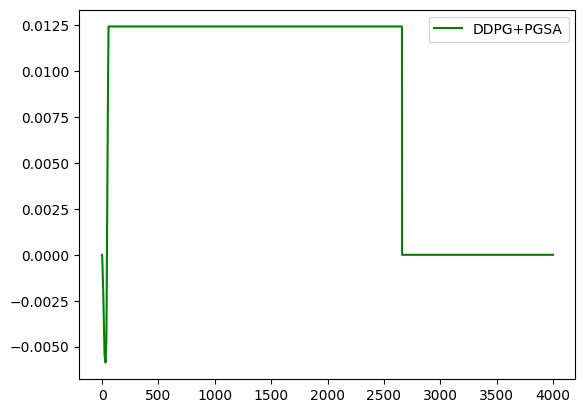

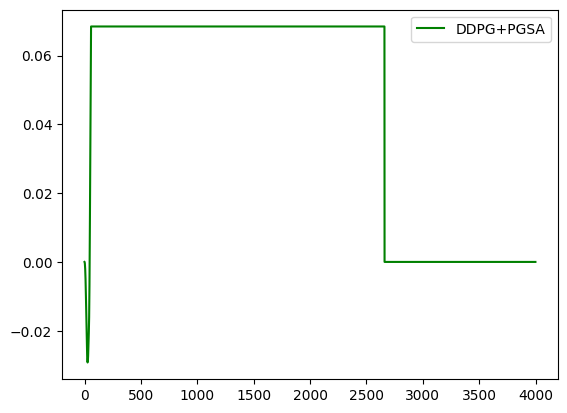

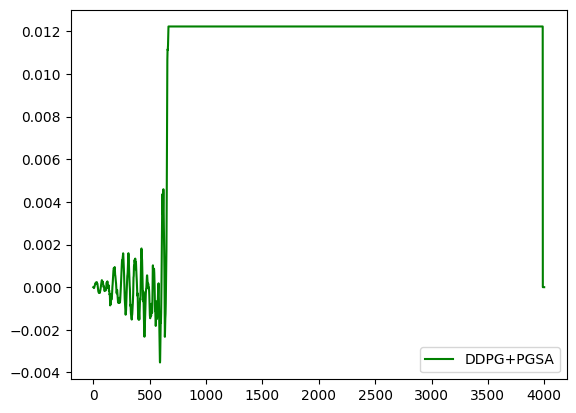

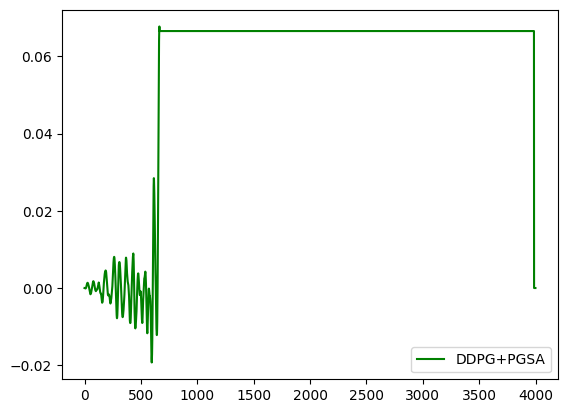

In [21]:
#  Control force
plt.figure()
plt.plot(xd[:,0, 0],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xd[:,7, 0],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xd[:,0, 4],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(xd[:,7, 4],'g',label='DDPG+PGSA')
plt.legend()


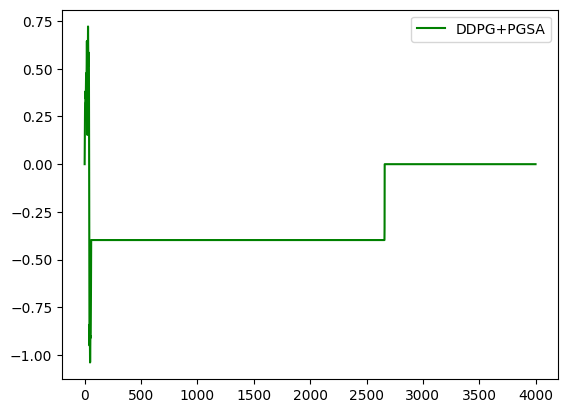

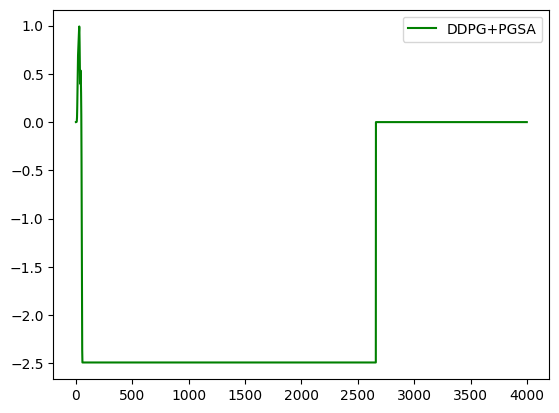

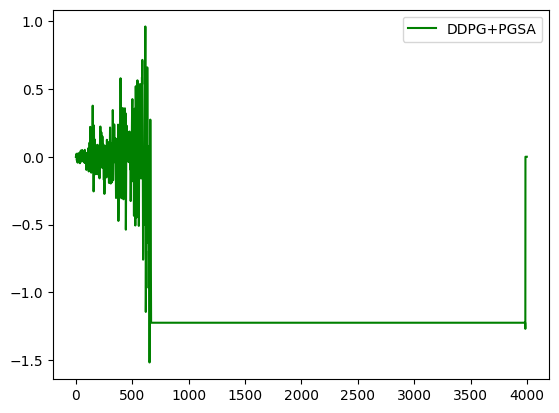

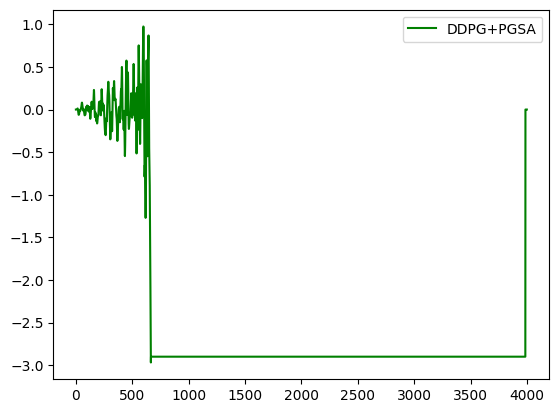

In [22]:
#  Control force
plt.figure()
plt.plot(yd[:,0, 0],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(yd[:,7, 0],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(yd[:,0, 4],'g',label='DDPG+PGSA')
plt.legend()

plt.figure()
plt.plot(yd[:,7, 4],'g',label='DDPG+PGSA')
plt.legend()
